Parsed excel file 'gs://gaitbfb_propellab/Wearable Biofeedback System (REB-0448)/Data/Raw Data/AB_P14/Excel_Data/VCL-002.csv'...
Parsed excel file 'gs://gaitbfb_propellab/Wearable Biofeedback System (REB-0448)/Data/Raw Data/AB_P14/Excel_Data/VCL-001.csv'...
Parsed excel file 'gs://gaitbfb_propellab/Wearable Biofeedback System (REB-0448)/Data/Raw Data/AB_P14/Excel_Data/VOL-001.csv'...
Parsed excel file 'gs://gaitbfb_propellab/Wearable Biofeedback System (REB-0448)/Data/Raw Data/AB_P14/Excel_Data/COL-005.csv'...
Parsed excel file 'gs://gaitbfb_propellab/Wearable Biofeedback System (REB-0448)/Data/Raw Data/AB_P14/Excel_Data/COL-003.csv'...
Parsed excel file 'gs://gaitbfb_propellab/Wearable Biofeedback System (REB-0448)/Data/Raw Data/AB_P14/Excel_Data/COL-002.csv'...
Parsed excel file 'gs://gaitbfb_propellab/Wearable Biofeedback System (REB-0448)/Data/Raw Data/AB_P14/Excel_Data/COL-001.csv'...
Parsed excel file 'gs://gaitbfb_propellab/Wearable Biofeedback System (REB-0448)/Data/Raw Data/AB

Text(0.5, 0, 'Stance Time Symmetry Ratio')

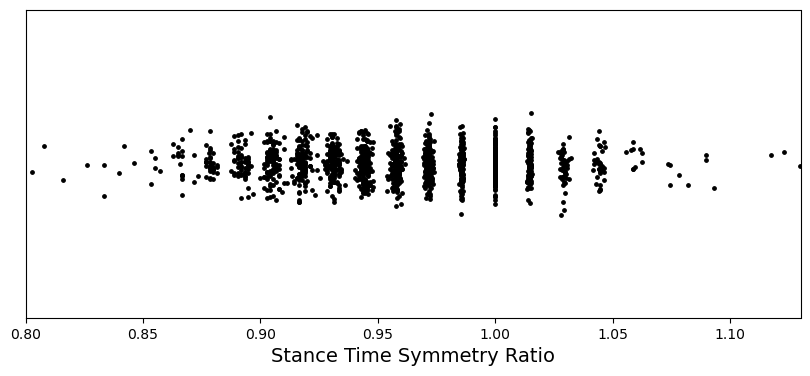

In [1]:
# import os
import importlib
import cloudstorage as gcs
from google.cloud import storage
import pandas as pd

import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import scipy.interpolate as interp
import numpy as np
import math
import sys
import time
import re
import os
import random
from control import get_control_data
import json
import scipy

from scipy import signal
import scipy.interpolate as interp
# import excel_reader_gcp_dot as excel_reader
# import excel_reader_gcp as excel_reader
import excel_reader_modular as excel_reader
# from random import shuffle
from dtw import dtw


plot_colors = ['black', 'red', 'orange', 'cyan', 'green', 'purple', 'blue']
use_manual_filenames = False

files = [
        ]

ab_or_llpu = 'AB'
bucket_dir = 'gs://gaitbfb_propellab/'
if(ab_or_llpu == 'AB'):
    # participant_info = bucket_dir + 'Wearable Biofeedback System (REB-0448)/Data/Raw Data/Data_Info_AB_v2.csv'
    participant_info = bucket_dir + 'Wearable Biofeedback System (REB-0448)/Data/Raw Data/Data_Info_AB_vG_5Sensors.csv'
else:
    participant_info = bucket_dir + 'Wearable Biofeedback System (REB-0448)/Data/Raw Data/Data_Info_LLPU.csv'

df = pd.read_csv(participant_info)
# participants = df['Participant'].unique()

# fig, axs = plt.subplots(2)


part_strides = {}
part_gait_params = {}
part_kinematic_params = {}
temp_len = 0

partitioned_signals_dot = []
target_SRs = []
nondesired_trial_nums = [4]
participant_of_interest = 14
sym_ranges= [[1.0, 1.2], [0.925, 0.98], [0.8, 0.92]]
look_at_all_files = True

signals_of_interest = ['Acc_X', 'Acc_Y', 'Acc_Z', 'Gyr_X', 'Gyr_Y', 'Gyr_Z']

# interpolate signal to convert to new frequency (for time aligning with xsens mvn system)
def convert_dot_freq(packetCount, downsampled_signal, old_freq=60, new_freq=100):
    x_o = np.array(packetCount)
    x_new = np.linspace(x_o[0], x_o[-1], int(x_o[-1] * (new_freq / old_freq)) )
    func_cubic = interp.interp1d(x_o, downsampled_signal, kind='cubic')
    y_new = func_cubic(x_new)
    return y_new

if(use_manual_filenames):
    for i, file in enumerate(files):
#         trial_type = re.search(initials + '_(.*)-00', os.path.join(bucket_dir, file)).group(1)
#         trial_type = re.search(initials + '_(.*?)_', os.path.join(bucket_dir, file)).group(1)     # AH/YM/MI naming convention
#         trial_type = re.search('-(.*)-001', os.path.join(bucket_dir, file)).group(1) # Able-bodied naming convention
        lower_body_strides, gait_param = excel_reader.process_trial_data(i, os.path.join(bucket_dir, file))
        # excel_reader.visualize_strides(lower_body_strides['knee_angle'][0], ax1, 2, i)
        # excel_reader.visualize_strides(lower_body_strides['knee_angle'][1], ax2, 2, i)

        if trial_type in part_strides:
            for body_part in part_strides[trial_type]:
                for i, side in enumerate(part_strides[trial_type][body_part]):
                    # for each part (pelvis, l_hip, r_knee, etc.), append strides to appropriate list
                    part_strides[trial_type][body_part][i] = part_strides[trial_type][body_part][i] + lower_body_strides[body_part][i]

        else:
            part_strides[trial_type] = lower_body_strides
            gait_params[trial_type] = gait_param          

else:
    
    XsensGaitParser = excel_reader.XsensGaitDataParser()
    
    storage_client = storage.Client()
    for index, row in df.iterrows():
        xsens_file = row['Xsens Filename'][:-4] + 'csv'
        prefix_from_bucket = 'Wearable Biofeedback System (REB-0448)/Data/Raw Data/' + row['Participant']
        # get app gait events for calculating gait parameters
        trial_num = row['App Filename']
        
        # participant_num = int(re.search('AB_P(.*)', row['Participant']).group(1))
        participant_num = int(re.search(ab_or_llpu + '_P(.*)', row['Participant']).group(1))
        
        if(participant_num == participant_of_interest):
        # if(True):
            trial_type = re.search('(.*)-0', row['Xsens Filename']).group(1)
            if(trial_type == 'Training'):
                dot_trial_type = 'COL'
            else:
                dot_trial_type = trial_type
            # if (trial_type == 'VOL'):
            if(True):
                for blob in storage_client.list_blobs('gaitbfb_propellab', prefix=os.path.join(prefix_from_bucket, 'App_Data/')):
                    file = blob.name
                # for file in os.listdir(os.path.join(bucket_dir, prefix_from_bucket, 'App_Data')):
                    if( ((str(trial_num) + '.json') in file) and (dot_trial_type in file) and not ('Audio' in file) and not ('._' in file)):
                        bfb_json_file = file
                        
                bucket = storage_client.get_bucket('gaitbfb_propellab')
                json_blob = bucket.blob(bfb_json_file)
                x = json.loads(json_blob.download_as_string(client=None))
                    
                initialSR = x['description']['initialSR']
                
                # gets unique sensor locations from logged data folder, i.e., ul, ur, p, etc.
                dot_sensor_data = list(set([f.name.strip('.csv').split('_')[-1] for f in storage_client.list_blobs('gaitbfb_propellab', 
                                                                                            prefix=os.path.join(prefix_from_bucket, 'App_Data_Logged/Renamed/'))
                                                                                           if not f.name[-1] == '/']))
                dot_sensor_data = dict.fromkeys(dot_sensor_data)
                temp_dot = {}
                
                for location in dot_sensor_data.keys():
                    for blob in storage_client.list_blobs('gaitbfb_propellab', prefix=os.path.join(prefix_from_bucket, 'App_Data_Logged/Renamed/')):
                        filename = blob.name 
                        if( ('_' + str(trial_num) + '_' + location) in filename):
                            temp_dot[filename] = None
                            
                # convert gait events to nearest index if sampled at 100Hz
                xsens_trial_num = int(re.search('-0(.*).mvnx', row['Xsens Filename']).group(1))
                if((not (xsens_trial_num in nondesired_trial_nums)) or (look_at_all_files)):

                    for location, filename in zip(dot_sensor_data.keys(), temp_dot.keys()):
                        temp_dot[filename] = pd.read_csv(os.path.join(bucket_dir, filename))
                        
                        # due to data pipeline, some csv files have "sep=," at beginning which needs to be removed/skipped for pd.read_csv to read columns correctly
                        if(len(temp_dot[filename].columns) == 2 ):
                            temp_dot[filename] = pd.read_csv(os.path.join(bucket_dir, filename), skiprows=1)

                        dot_sensor_data[location] = np.array([convert_dot_freq(temp_dot[filename]['PacketCounter'], temp_dot[filename][sig]) for sig in signals_of_interest]).T

                    def partition_dot_by_gait_event(xsens_dot_signal, gait_events, side):
                        partitioned_signals = []
                        # print(xsens_dot_signal.shape)
                        if(side == 'r'):
                            for stride in gait_events:
                                partitioned_signals.append(xsens_dot_signal[stride[0]:stride[2], :])

                        else:
                            for stride in gait_events:
                                partitioned_signals.append(xsens_dot_signal[stride[3]:stride[5], :])

                        return partitioned_signals

                    # load Xsens MVN full data
                    xsens_path_file = os.path.join(bucket_dir, prefix_from_bucket, 'Excel_Data/', xsens_file)
                    # lower_body_strides, gait_params, partitioned_dot_signal = excel_reader.process_trial_data(0, xsens_path_file, xsens_dot[0][-1], stride_events)
                    # lower_body_strides, gait_params, partitioned_signals = excel_reader.process_trial_data(0, xsens_path_file, dot_sensor_data)
                    XsensGaitParser.process_mvn_trial_data(xsens_path_file)
                    partitioned_mvn_data = XsensGaitParser.get_partitioned_mvn_data()
                    gait_params = XsensGaitParser.get_gait_param_info()

                    partitioned_signals_dot.append(XsensGaitParser.time_align_mvn_and_dot(dot_sensor_data))

                    # trial_type = str(xsens_trial_num)
                    trial_type = 'AB'
                    target_SRs.append(initialSR)
                    if trial_type in part_strides:
                        for body_part in part_strides[trial_type]:
                            for i, side in enumerate(part_strides[trial_type][body_part]):
                                # for each part (pelvis, l_hip, r_knee, etc.), append strides to appropriate list
                                part_strides[trial_type][body_part][i] = part_strides[trial_type][body_part][i] + partitioned_mvn_data[body_part][i]

                        part_gait_params[trial_type].append(gait_params['spatio_temp'])
                        # print(part_gait_params['AB'])

                        for joint in part_kinematic_params[trial_type]:
                            for i, side in enumerate(part_kinematic_params[trial_type][joint]):
                                part_kinematic_params[trial_type][joint][i] = np.append(part_kinematic_params[trial_type][joint][i], gait_params['kinematics'][joint][i], axis=0)

                    else:
                        part_strides[trial_type] = partitioned_mvn_data
                        part_gait_params[trial_type] = [gait_params['spatio_temp']]
                        part_kinematic_params[trial_type] = gait_params['kinematics']


                    # cur_len = len(part_strides['AB']['knee_angle'][0]) - temp_len
                    # print(cur_len)
                    # temp_len = temp_len + cur_len
    
    
resize_len = 40

def reshape_vector(vectors_orig, new_size, num_axes = 3):
    x_new = np.linspace(0, 100, new_size)
    trial_reshaped = []

    for stride in vectors_orig:
        # print(stride.shape)
        x_orig = np.linspace(0, 100, len(stride))
        func_cubic = [interp.interp1d(x_orig, stride[:,i], kind='cubic') for i in range(6)]
        vec_cubic = np.array([func_cubic[i](x_new) for i in range(num_axes)]).transpose()
        trial_reshaped.append(vec_cubic)

    return np.array(trial_reshaped)

b20, a20 = scipy.signal.butter(N=4, Wn = 0.4, btype = 'lowpass')  # Wn = 0.2 = 10 / Nyquist F = 50Hz

# excel_reader.visualize_strides(xsens_dot_partitioned_by_ge_baseline[:,:,3:], ax1, 0, 0)
sensor_locs = partitioned_signals_dot[0].keys()
# print(sensor_locs)
for i in range(len(partitioned_signals_dot)):
    for sensor_location in sensor_locs:
        partitioned_signals_dot[i][sensor_location] = reshape_vector(partitioned_signals_dot[i][sensor_location], resize_len, 6)

# temp = -2
# for sensor_location in partitioned_signals_dot[temp]:
#     # print(sensor_location)
#     # print(i)
#     partitioned_signals_dot[i][sensor_location] = reshape_vector(partitioned_signals_dot[temp][sensor_location], resize_len, 6)
partitioned_signals_dot_grouped = {}
overflow_check = []
num_strides = len(partitioned_signals_dot)

for sensor_location in sensor_locs:
    partitioned_signals_dot_grouped[sensor_location] = np.concatenate([x[sensor_location] for x in partitioned_signals_dot], axis=0)
    for i, stride in enumerate(partitioned_signals_dot_grouped[sensor_location]):
        if (np.max(stride) > 1000):
            overflow_check.append(i)
            
for sensor_location in sensor_locs:
    partitioned_signals_dot_grouped[sensor_location] = np.delete(partitioned_signals_dot_grouped[sensor_location], overflow_check, axis=0)

target_SRs.reverse()
training_symmetries = []
for i in range(len(part_gait_params['AB'])):
    training_symmetries.append([j for j in part_gait_params['AB'][i][12]])

stance_time_symmetry = [item for sublist in [i[12] for i in part_gait_params['AB']] for item in sublist]
stance_time_symmetry = np.delete(stance_time_symmetry, overflow_check)
knee_ROMs = [item for sublist in [i[13] for i in part_gait_params['AB']] for item in sublist]
knee_ROMs_R_flex = [i[0,2] for i in knee_ROMs]
knee_ROMs_L_flex = [i[1,2] for i in knee_ROMs]
hip_ROMs = [item for sublist in [i[14] for i in part_gait_params['AB']] for item in sublist]
hip_ROMs_R_flex = [i[0,2] for i in hip_ROMs]
hip_ROMs_L_flex = [i[1,2] for i in hip_ROMs]

# print(len(knee_ROMs_R_flex))
step_lengths_R = [item for sublist in [i[10][0] for i in part_gait_params['AB']] for item in sublist]
step_lengths_L = [item for sublist in [i[10][1] for i in part_gait_params['AB']] for item in sublist]
stride_lengths = [item for sublist in [i[15][0] for i in part_gait_params['AB']] for item in sublist]
speed = [item for sublist in [i[16] for i in part_gait_params['AB']] for item in sublist]
speed = np.delete(speed, overflow_check)
cadence = [item for sublist in [i[17] for i in part_gait_params['AB']] for item in sublist]
cadence = np.delete(cadence, overflow_check)


print('Mean Speed: %.3f ± %.3f' % (np.mean(speed), np.std(speed)))
print('Mean Cadence: %.3f ± %.3f' % (np.mean(cadence), np.std(cadence)))
print('')

print()
print('Num strides: ', len(stance_time_symmetry))
print('Mean symmetry: %.3f ± %.3f' % (np.mean(stance_time_symmetry), np.std(stance_time_symmetry)))
print('Upper 95% of the data: ', sorted(stance_time_symmetry)[round(0.95 * len(stance_time_symmetry))])
print('Lower 95% of the data: ', sorted(stance_time_symmetry)[round(0.05 * len(stance_time_symmetry))])
print()

training_symmetries.reverse()
partitioned_signals_dot.reverse()

# for i, symmetries in enumerate(training_symmetries):
#     # print(len(symmetries))
#     # print(len(partitioned_signals_dot[i]['LowerR']))
#     y = (np.ones(len(symmetries)) * target_SRs[i]) + np.random.normal(0,  0.02, len(symmetries))
#     plt.scatter(symmetr, y, s = 6)

# plt.show()
# plt.figure()
# y = (np.ones(len(stance_time_symmetry))) + np.random.normal(0, 0.02, len(stance_time_symmetry))
# plt.hist(stance_time_symmetry, bins = 25)
    
# if(ab_or_llpu == 'AB'):
#     plt.xlim([0.7, 1.10])
# else:
#     plt.xlim([0.8, 1.2])

plt.figure(figsize = (10, 4))

y = (np.zeros(len(stance_time_symmetry))) + np.random.normal(0,  0.02, len(stance_time_symmetry))
plt.scatter(stance_time_symmetry, y, s = 6, color='black')
    
if(ab_or_llpu == 'AB'):
    plt.xlim([0.8, 1.13])
else:
    plt.xlim([0.8, 1.2])
    
plt.ylim([-0.2, 0.2])
ax_set = plt.gca()
ax_set.get_yaxis().set_visible(False)

plt.xlabel('Stance Time Symmetry Ratio', fontsize = 14)

# fig, axs = plt.subplots(2)
# excel_reader.visualize_strides(partitioned_signals_dot[0]['LowerL'][:,:,5], axs[0], 0, 0)
# excel_reader.visualize_strides(partitioned_signals_dot[1]['LowerL'][:,:,5], axs[0], 0, 1)
# excel_reader.visualize_strides(partitioned_signals_dot[2]['LowerL'][:,:,5], axs[0], 0, 2)
# # excel_reader.visualize_strides(partitioned_signals_dot[3]['LowerL'][:,:,5], axs[0], 0, 3)

# excel_reader.visualize_strides(partitioned_signals_dot[0]['LowerR'][:,:,5], axs[1], 0, 0)
# excel_reader.visualize_strides(partitioned_signals_dot[1]['LowerR'][:,:,5], axs[1], 0, 1)
# excel_reader.visualize_strides(partitioned_signals_dot[2]['LowerR'][:,:,5], axs[1], 0, 2)
# # excel_reader.visualize_strides(partitioned_signals_dot[3]['LowerR'][:,:,5], axs[1], 0, 3)
# plt.show()

# fig, axs = plt.subplots(2)
# excel_reader.visualize_strides(partitioned_signals_dot[0]['UpperL'][:,:,5], axs[0], 0, 0)
# excel_reader.visualize_strides(partitioned_signals_dot[1]['UpperL'][:,:,5], axs[0], 0, 1)
# excel_reader.visualize_strides(partitioned_signals_dot[2]['UpperL'][:,:,5], axs[0], 0, 2)
# # excel_reader.visualize_strides(partitioned_signals_dot[3]['LowerL'][:,:,5], axs[0], 0, 3)

# excel_reader.visualize_strides(partitioned_signals_dot[0]['UpperR'][:,:,5], axs[1], 0, 0)
# excel_reader.visualize_strides(partitioned_signals_dot[1]['UpperR'][:,:,5], axs[1], 0, 1)
# excel_reader.visualize_strides(partitioned_signals_dot[2]['UpperR'][:,:,5], axs[1], 0, 2)

# plt.show()


Number of strides in Avg. Sym - 1.024: 195
Number of strides in Avg. Sym - 0.959: 277
Number of strides in Avg. Sym - 0.896: 189
Total strides used for training:  661


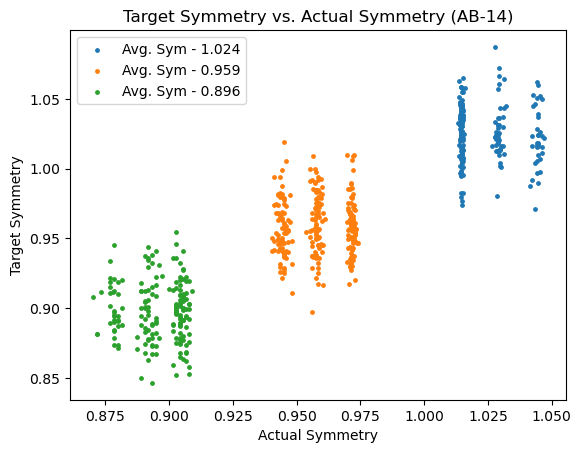

dict_keys(['LowerR', 'LowerL', 'UpperR', 'Pelvis', 'UpperL'])
Mean standard deviation: 2.0062
Mean standard deviation: 2.0477
(277, 40, 6)
Mean standard deviation: 1.2580
Mean standard deviation: 1.1284


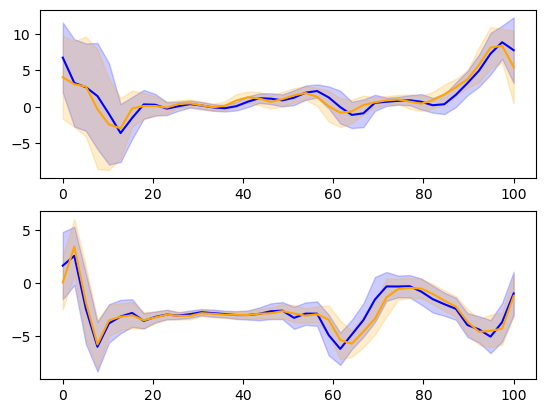

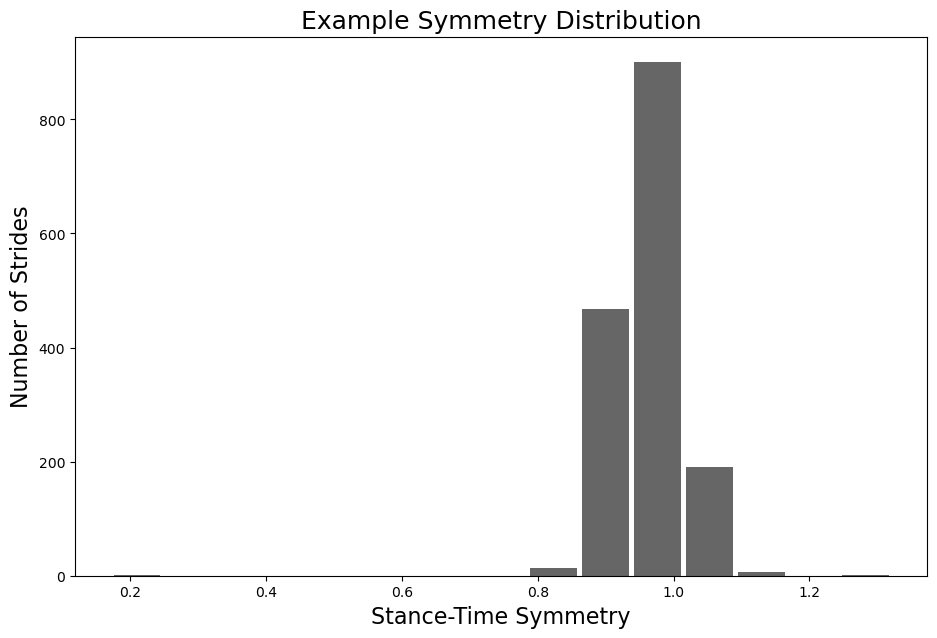

In [2]:
import seaborn as sns
max_size = 0
# sym_ranges= [[0.995, 1.04], [0.91, 0.97], [0.78, 0.89]]   # AB3
# sym_ranges= [[0.995, 1.04], [0.90, 0.955], [0.81, 0.88]]   # AB5
# sym_ranges= [[0.98, 1.02], [0.93, 0.97], [0.86, 0.92]]   # AB6
# sym_ranges= [[0.97, 1.03], [0.87, 0.93], [0.75, 0.83]]    # AB8
# sym_ranges= [[1.01, 1.2], [0.93, 1.0], [0.8, 0.92]]   # AB9
# sym_ranges= [[0.99, 1.02], [0.95, 0.98], [0.89, 0.93]]    # AB10
# sym_ranges= [[0.97, 1.1], [0.87, 0.93], [0.75, 0.83]]    # AB11

# 3 DIFFERENT SYMMETRY LEVELS
sym_ranges= [[1.01, 1.05], [0.94, 0.98], [0.87, 0.91]]    # AB14
# sym_ranges= [[1.07, 1.13], [1.00, 1.04], [0.90, 0.98]]    # AB15
# sym_ranges= [[1.02, 1.07], [0.97, 1.01], [0.88, 0.95]]    # AB16
# sym_ranges= [[1.02, 1.07], [0.97, 1.01], [0.90, 0.95]]    # AB19
# sym_ranges= [[1.02, 1.05], [0.98, 1.01], [0.89, 0.96]]    # AB20
# sym_ranges= [[0.98, 1.02], [0.90, 0.95], [0.83, 0.87]]    # AB22
# sym_ranges= [[0.99, 1.04], [0.91, 0.96], [0.83, 0.88]]    # AB23
# sym_ranges= [[0.98, 1.02], [0.94, 0.97], [0.87, 0.93]]    # AB24
# sym_ranges= [[0.99, 1.03], [0.95, 0.98], [0.89, 0.94]]    # AB25
# sym_ranges= [[1.01, 1.04], [0.97, 1.01], [0.92, 0.96]]    # AB26
# sym_ranges= [[0.99, 1.05], [0.955, 0.98], [0.88, 0.95]]    # AB27
# sym_ranges= [[0.95, 0.99], [0.91, 0.94], [0.85, 0.90]]    # AB28

# 2 SYMMETRY LEVELS, FOR TESTING WHEN WE SPLIT EACH INTO TWO AND COMPARE RESULTS
# sym_ranges= [[0.99, 1.05], [0.90, 0.94]]    # AB14
# sym_ranges= [[1.06, 1.11], [0.97, 1.035]]   # AB15 maybe 1.03 instead
# sym_ranges= [[1.01, 1.05], [0.92, 0.97]]  # AB16
# sym_ranges= [[1.01, 1.05], [0.94, 0.98]]    # AB19
# sym_ranges= [[0.95, 1.01], [0.85, 0.90]]    # AB22
# sym_ranges= [[0.96, 1.02], [0.86, 0.92]]    # AB23
# sym_ranges= [[0.96, 1.01], [0.89, 0.94]]    # AB24
# sym_ranges= [[0.98, 1.02], [0.92, 0.96]]    # AB25
# sym_ranges= [[1.00, 1.06], [0.94, 0.99]]    # AB26 not as many strides available for this one
# sym_ranges= [[0.98, 1.05], [0.90, 0.97]]    # AB27
# sym_ranges= [[0.93, 1.00], [0.85, 0.91]]    # AB28

# 2 SYMMETRY LEVELS, alternate symmetry split (for only one split in half)
# sym_ranges= [[0.99, 1.05], [0.90, 0.95]]    # AB14
# sym_ranges= [[1.06, 1.12], [0.97, 1.035]]   # AB15 maybe 1.03 instead
# sym_ranges= [[1.01, 1.05], [0.92, 0.99]]  # AB16
# sym_ranges= [[1.01, 1.05], [0.92, 0.99]]    # AB19
# sym_ranges= [[0.95, 1.01], [0.85, 0.93]]    # AB22 # keep an eye on this one
# sym_ranges= [[0.98, 1.02], [0.86, 0.95]]    # AB23
# sym_ranges= [[0.90, 0.94], [0.96, 1.01]]    # AB24
# sym_ranges= [[0.98, 1.02], [0.91, 0.96]]    # AB25
# sym_ranges= [[1.01, 1.06], [0.93, 1.005]]    # AB26 not as many strides available for this one
# sym_ranges= [[0.99, 1.05], [0.90, 0.99]]    # AB27
# sym_ranges= [[0.93, 1.00], [0.85, 0.92]]    # AB28

# 2 symmetry levels, correcting for gait cycle number imbalance
# sym_ranges= [[0.99, 1.02], [0.94, 0.96]]    # AB14
# sym_ranges= [[1.01, 1.04], [0.96, 0.99]]  # AB16




# sym_ranges= [[0.95, 1.06], [0.95, 1.06], [0.80, 0.87], [0.75, 0.85]]    # AB8, two tiers, two trials in each
# sym_ranges= [[0.94, 1.05], [0.94, 1.05], [0.94, 1.05], [0.75, 0.85]]    # AB11, two tiers, three trial in one, one in other
sym_range_strides = {}
symmetry_split_into_ranges = []
sym_strides_to_add = [ [] for _ in range(len(sym_ranges))]
# print((xsens_dot_partitioned_by_ge[0].shape))
for i in range(len(stance_time_symmetry)):
    for j in range(len(sym_ranges)):
        if((stance_time_symmetry[i] > sym_ranges[j][0]) and (stance_time_symmetry[i] < sym_ranges[j][1])):
            sym_strides_to_add[j].append(i)
            break
        
if(participant_of_interest == 14):
    np.random.shuffle(sym_strides_to_add[0])
    sym_strides_to_add[0] = sym_strides_to_add[0][:203]
    np.random.shuffle(sym_strides_to_add[1])
    sym_strides_to_add[1] = sym_strides_to_add[1][::2]
    
if(participant_of_interest == 16):
    np.random.shuffle(sym_strides_to_add[0])
    sym_strides_to_add[0] = sym_strides_to_add[0][:203]
    
    np.random.shuffle(sym_strides_to_add[1])
    sym_strides_to_add[1] = sym_strides_to_add[1][:203]
        
trial_types = []
strides_used_for_training = 0
for i in range(len(sym_ranges)):
    symmetry_split_into_ranges.append( np.array([stance_time_symmetry[k] for k in sym_strides_to_add[i]]) )
    trial_types.append('Avg. Sym - ' + str( np.round( np.mean(symmetry_split_into_ranges[-1]), 3) ) )
    sym_range_strides[trial_types[-1]] = {}
    for sensor in sensor_locs:
        sym_range_strides[trial_types[-1]][sensor] = partitioned_signals_dot_grouped[sensor][sym_strides_to_add[i]]
    print('Number of strides in %s: %d' % (trial_types[-1], len(sym_range_strides[trial_types[-1]]['Pelvis'])))
    strides_used_for_training = strides_used_for_training + len(sym_range_strides[trial_types[-1]]['Pelvis'])
    
print('Total strides used for training: ', strides_used_for_training)
for i, symmetries in enumerate(symmetry_split_into_ranges):
    y = (np.ones(len(symmetries)) * np.mean(symmetries)) + np.random.normal(0,  0.02, len(symmetries))
    plt.scatter(symmetries, y, s = 6)
    
plt.title('Target Symmetry vs. Actual Symmetry (%s-%d)' % (ab_or_llpu, participant_of_interest))
plt.xlabel('Actual Symmetry')
plt.ylabel('Target Symmetry')
plt.legend(trial_types)
plt.show()
    

fig, axs = plt.subplots(2)
plt_axis = 2
print(sym_range_strides[trial_types[0]].keys())
excel_reader.visualize_strides(sym_range_strides[trial_types[0]]['UpperR'][:,:,plt_axis], axs[0], 0, 0)
excel_reader.visualize_strides(sym_range_strides[trial_types[1]]['UpperR'][:,:,plt_axis], axs[0], 0, 1)
# excel_reader.visualize_strides(sym_range_strides[trial_types[2]]['Pelvis'][:,:,plt_axis], axs[0], 0, 2)

print(sym_range_strides[trial_types[1]]['Pelvis'][:,:,0:].shape)
# excel_reader.visualize_strides(partitioned_signals_dot[3]['LowerL'][:,:,plt_axis], axs[0], 0, 3)

excel_reader.visualize_strides(sym_range_strides[trial_types[0]]['LowerL'][:,:,plt_axis], axs[1], 0, 0)
excel_reader.visualize_strides(sym_range_strides[trial_types[1]]['LowerL'][:,:,plt_axis], axs[1], 0, 1)
# excel_reader.visualize_strides(sym_range_strides[trial_types[2]]['LowerR'][:,:,plt_axis], axs[1], 0, 2)
# excel_reader.visualize_strides(partitioned_signals_dot[3]['LowerR'][:,:,plt_axis], axs[1], 0, 3)
plt.show()

plt.figure(figsize = (11,7))
plt.hist(stance_time_symmetry, bins = 15, density=False, rwidth=0.9, color='black', alpha = 0.6)
plt.xlabel('Stance-Time Symmetry', fontsize=16)
plt.ylabel('Number of Strides', fontsize=16)
plt.title('Example Symmetry Distribution', fontsize=18)
# plt.range()
plt.show()
        

In [3]:
# TRAINING 3 SYMMETRY LEVELS, NO SPLITTING OF THE STRIDES IN THE SYMMETRY RANGES

from hmmlearn import hmm
import seaborn as sns

partitioned_strides = {}
for i, trial_type in enumerate(trial_types):
    partitioned_strides[trial_type] = sym_range_strides[trial_type]['Pelvis'][:,:,0:]
    # partitioned_strides[trial_type] = np.concatenate([sym_range_strides[trial_type]['LowerR'][:,:,0:], sym_range_strides[trial_type]['LowerL'][:,:,0:]], axis=2)
    np.random.shuffle(partitioned_strides[trial_type])
    print('Number of %s strides: %d' % (trial_type, len(partitioned_strides[trial_type])))
# pre_strides = partitioned_signals_dot['Pre']['LowerL'][:,:,3:]
# post_strides = partitioned_signals_dot['PostRehab']['LowerL'][:,:,3:]
# cr_strides = partitioned_signals_dot['CueingRemoved']['LowerL'][:,:,3:]
print()
# concatenate multiple strides together. Done in a "sliding window" over gait cycles, to still have reasonable amount of training samples
pre_strides_concat = []
post_strides_concat = []
cr_strides_concat = []

concat_strides = {}
strides_to_concat = 4

for trial_type in trial_types:
    concat_strides[trial_type] = []
    for i in range(partitioned_strides[trial_type].shape[0] - strides_to_concat):
        temp = []
        for j in range(strides_to_concat):
            temp.append(partitioned_strides[trial_type][i + j])

        concat_strides[trial_type].append(np.concatenate(temp, axis=0))
    
    concat_strides[trial_type] = np.array(concat_strides[trial_type])
    concat_strides[trial_type] = signal.filtfilt(b20, a20, concat_strides[trial_type], axis=1)
    
# for i in range(3,8):
#     plt.figure(figsize=(8, 3))
#     for j in range(6):
#         x = concat_strides[trial_types[2]][0, :, j]
#         if(j < 3):
#             x = x * 3
            
#         if(j < 5):
#             plt.plot(x, 'k', alpha=0.3)
#         else:
#             plt.plot(x, 'k')
#     # plt.plot(concat_strides[trial_types[0]][20, :, 5])
#     plt.show()

Number of Avg. Sym - 1.024 strides: 195
Number of Avg. Sym - 0.959 strides: 277
Number of Avg. Sym - 0.896 strides: 189



Training Avg. Sym - 1.024 models...
Train Attempt  2
Train Attempt  1
Train Attempt  1
Train Attempt  1
Train Attempt  9
Train Attempt  2
Train Attempt  2
Train Attempt  1
Train Attempt  2
Train Attempt  2
Training Avg. Sym - 0.959 models...
Train Attempt  2
Train Attempt  2
Train Attempt  1
Train Attempt  1
Train Attempt  1
Train Attempt  3
Train Attempt  1
Train Attempt  1
Train Attempt  1
Train Attempt  4
Training Avg. Sym - 0.896 models...
Train Attempt  1
Train Attempt  2
Train Attempt  3
Train Attempt  4
Train Attempt  1
Train Attempt  1
Train Attempt  3
Train Attempt  1
Train Attempt  2
Train Attempt  6
done
[[6.49244081e-001 3.50055935e-001 3.52261395e-113 6.99983878e-004
  5.85141566e-036]
 [3.41325813e-182 1.38007025e-001 8.61992975e-001 2.22074908e-061
  2.39764895e-028]
 [1.94992417e-034 9.57779038e-172 5.57530018e-001 4.42469982e-001
  2.21432730e-028]
 [1.76197466e-022 1.74747579e-107 3.03450249e-032 7.63361708e-001
  2.36638292e-001]
 [3.07575850e-001 2.42123673e-068 5.7

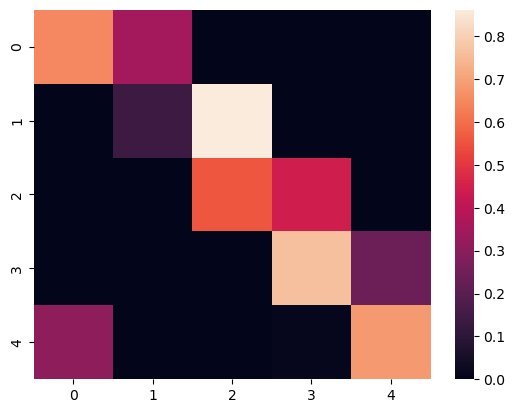

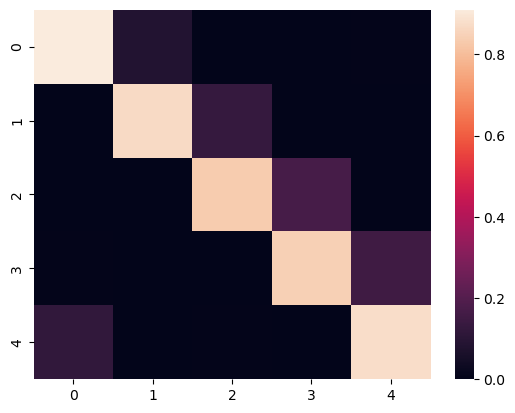

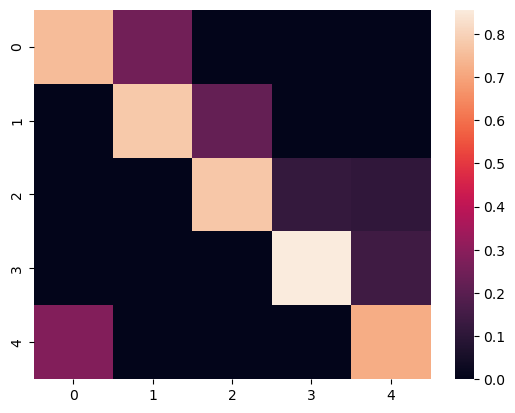

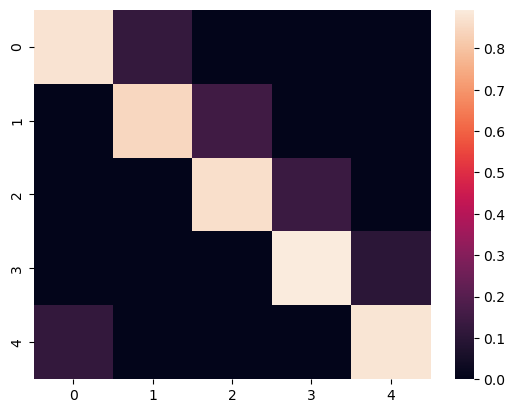

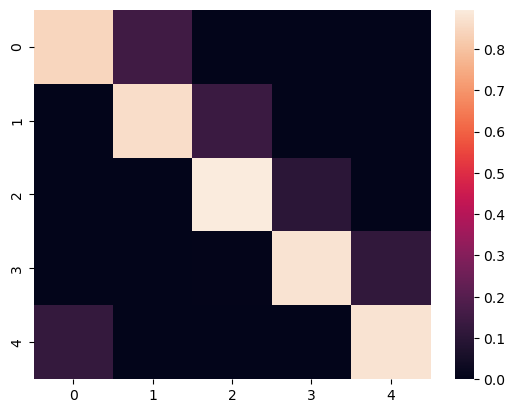

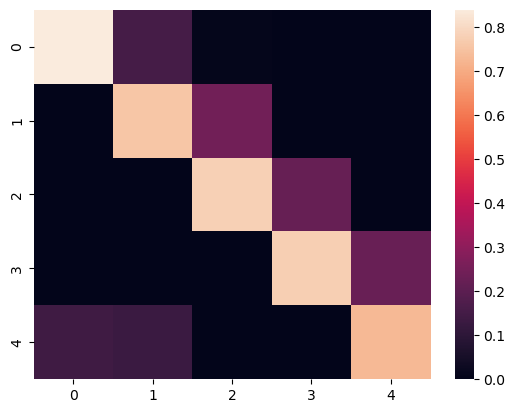

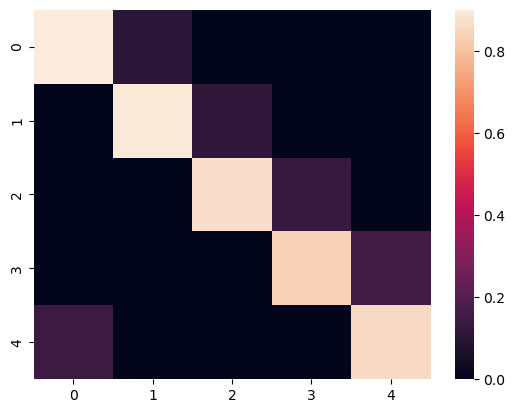

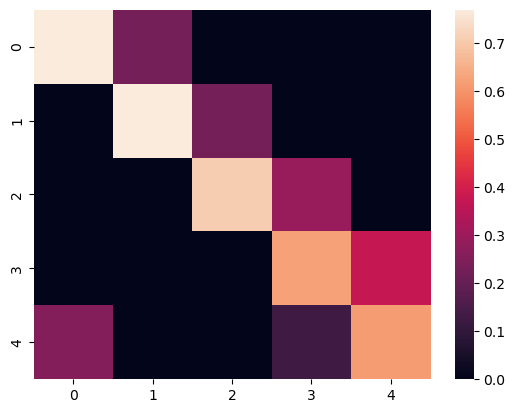

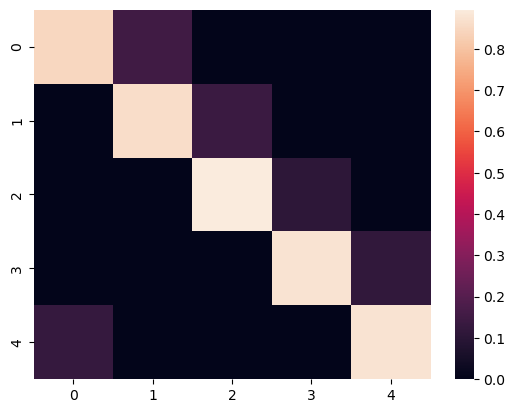

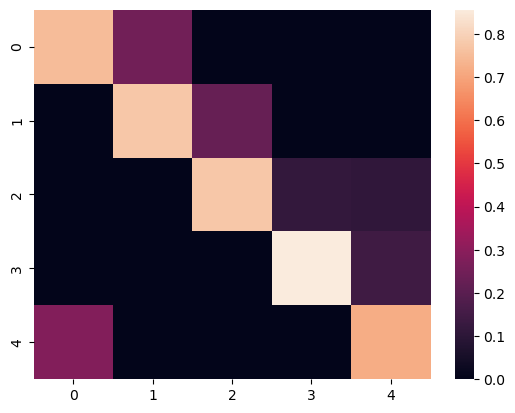

In [11]:
# for i in range(pre_strides.shape[0] - strides_to_concat):
#     temp = []
#     for j in range(strides_to_concat):
#         temp.append(pre_strides[i + j])
        
#     pre_strides_concat.append(np.concatenate(temp, axis=0))
    
# for i in range(post_strides.shape[0] - strides_to_concat):
#     temp = []
#     for j in range(strides_to_concat):
#         temp.append(post_strides[i + j])
        
#     post_strides_concat.append(np.concatenate(temp, axis=0))

# pre_strides_concat = np.array(pre_strides_concat)
# post_strides_concat = np.array(post_strides_concat)


# pre_strides_concat = signal.filtfilt(b20, a20, pre_strides_concat, axis=1)
# post_strides_concat = signal.filtfilt(b20, a20, post_strides_concat, axis=1)

class HMMTrainer(object):
    def __init__(self, model_name='GaussianHMM', n_components=4, cov_type='full', n_iter=50, tolerance = 0.005):
        self.model_name = model_name
        self.n_components = n_components
        self.cov_type = cov_type
        self.n_iter = n_iter
        self.models = []
        if self.model_name == 'GaussianHMM':
            # self.model = hmm.GaussianHMM(n_components=self.n_components, covariance_type=self.cov_type, n_iter=self.n_iter, tol=tolerance, params='stmc', init_params='stmc', verbose=False)
            self.model = hmm.GaussianHMM(n_components=self.n_components, covariance_type=self.cov_type, n_iter=self.n_iter, tol=tolerance, params='stmc', init_params='mc', verbose=False)
            self.model.transmat_ = np.zeros((n_components, n_components))
            for i in range(n_components):
                self.model.transmat_[i, 0:2] = np.random.dirichlet(np.ones(2)/1.5, size=1)
                self.model.transmat_[i, 2:] = np.random.dirichlet(np.ones(self.n_components - 2), size=1)[0] / 1e80
                self.model.transmat_[i] = np.roll(self.model.transmat_[i], i)

        else:
            raise TypeError('Invalid model type') 

    # resize_len = num_samples
    def train(self, X, resize_len, num_sequences):
        np.seterr(all='ignore')
        
        self.model.fit(X, lengths=resize_len * np.ones(num_sequences, dtype=int))
        # x_concat = np.concatenate(X).reshape(-1,1)
        # self.models.append(self.model.fit(X))
        # self.models.append(self.model.fit(x_concat, lengths = [X.shape[1] for i in range(X.shape[0])]))
        # Run the model on input data
    def get_score(self, input_data):
        return self.model.score(input_data)
        # return self.model.score(input_data.reshape(-1,1))

strides_train_flat = {}
strides_test_flat = {}
strides_train = {}
strides_test = {}

# pre_strides_test_flat = []
# post_strides_test_flat = []
# cr_strides_test_flat = []

num_states=5
train_iterations = 300
train_tolerance = 0.01

hmm_models = {}
num_models_train = 10

for trial_type in trial_types:
    print('Training %s models...' % (trial_type))
    hmm_models[trial_type] = []
    
    for j in range(num_models_train):
        train_forward_model = True
        k = 0

        while(train_forward_model):
            print('Train Attempt ', k+1, end="\r", flush=True)
            if(j > -1):
                np.random.shuffle(concat_strides[trial_type])
            strides_sequence_flattened = concat_strides[trial_type].reshape((concat_strides[trial_type].shape[0] * concat_strides[trial_type].shape[1], -1))
            len_train = int(0.95 * len(concat_strides[trial_type]))
            strides_train[trial_type] = concat_strides[trial_type][:len_train]
            strides_test[trial_type] = concat_strides[trial_type][len_train:]
            sequence_length = resize_len * strides_to_concat
            strides_train_flat[trial_type] = strides_sequence_flattened[:sequence_length * len_train]
            strides_test_flat[trial_type] = strides_sequence_flattened[sequence_length * len_train:]

            hmm_model = HMMTrainer(n_components = num_states, n_iter = train_iterations, tolerance = train_tolerance)
            hmm_model.train(strides_train_flat[trial_type], sequence_length, len_train)

            valid_rows = 0
            a_mat = hmm_model.model.transmat_
            for i, row in enumerate(a_mat):
                temp = np.argpartition(np.roll(row, -i), -2)[-2:]
                if((np.array(temp) == np.array([0,1])).all() or (np.array(temp) == np.array([1,0])).all()):
                    valid_rows = valid_rows + 1
            
            # correct_second_state = [i for i in range(num_states - 1)]
            # correct_second_state.append(0)
            # valid_rows = 0
            # for i, row in enumerate(hmm_model.model.transmat_):
            #     max_state = np.argmax(row)
            #     if(max_state == i):
            #         temp = [j for j in row if not (j == row[max_state])]
            #         if(np.argmax(temp) == correct_second_state[i]):
            #             valid_rows = valid_rows + 1

            if(valid_rows == num_states):
                train_forward_model = False
            k = k + 1

        print()
        hmm_models[trial_type].append(hmm_model)
    
print('done')
# print(len(pre_strides))
# print(len(post_strides))

# num_classified_pre = 0
# num_classified_post = 0

# print('Number of test strides: ', len(partitioned_strides[trial_types[0]]))
# for stride_test in partitioned_strides[trial_types[0]]:
#     score_label = []
#     # max_score = -99999999999999999
#     output_label = None
    
#     # score_pre = hmm_pre.get_score(stride_test)
#     score_pre = hmm_models[trial_types[0]][0].get_score(stride_test)
#     score_post = hmm_models[trial_types[2]][0].get_score(stride_test)
    
#     if(score_pre > score_post):
#         num_classified_pre = num_classified_pre + 1
#     elif(score_post > score_pre):
#         num_classified_post = num_classified_post + 1
    
# print('Accuracy: %.4f' % ( 100 * (num_classified_post / len(partitioned_strides[trial_types[0]])) ))

# sns.heatmap(hmm_models[trial_types[0]][0].model.transmat_)
# plt.figure()
# sns.heatmap(hmm_models[trial_types[2]][0].model.transmat_)


for spec_model in hmm_models[trial_types[0]]:
    print(spec_model.model.transmat_)
    plt.figure()
    sns.heatmap(spec_model.model.transmat_)


0


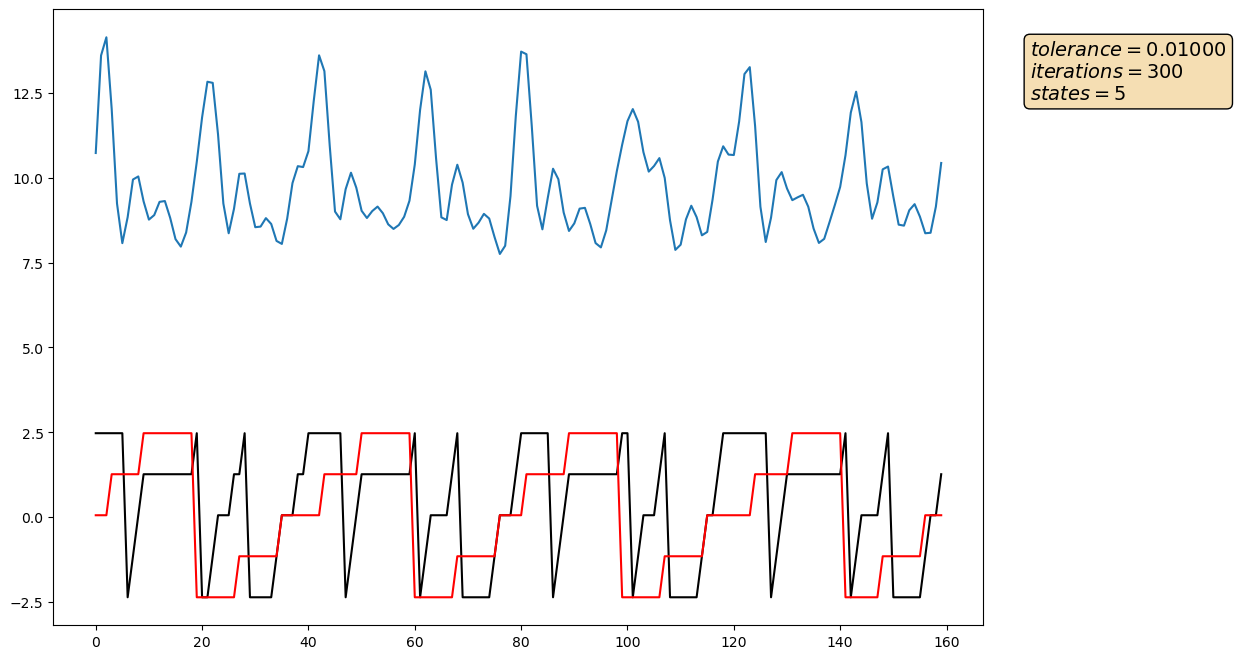

[0.00000000e+00 0.00000000e+00 1.36416281e-87 1.70342017e-08
 9.99999983e-01]
[0.02351896 0.         0.9590582  0.01742283 0.        ]


In [12]:
import copy
import seaborn as sns

test_predict = strides_test[trial_types[0]][1]
min_predict = np.min(test_predict[:,1])
max_predict = np.max(test_predict[:,1])

def align_states(trained_hmm_model, roll_amount=0):
    new_hmm = copy.deepcopy(trained_hmm_model)
    array_order = np.roll(np.arange(num_states), roll_amount)

    new_hmm.model.transmat_ = new_hmm.model.transmat_[array_order,: ]
    for i, row in enumerate(new_hmm.model.transmat_):
        new_hmm.model.transmat_[i] = np.roll(new_hmm.model.transmat_[i], roll_amount)
        
    new_hmm.model.means_ = new_hmm.model.means_[array_order, :]
    new_hmm.model.covars_ = new_hmm.model.covars_[array_order, :]
    new_hmm.model.startprob_ = new_hmm.model.startprob_[array_order]
    return new_hmm 

pred_vals = np.ones(num_states)
for i in range(num_states):
    pred_vals[i] = min_predict + ((i * (max_predict - min_predict)) / (num_states - 1))

    
# roll_amounts = {'Pre': [0,3,0,0,2],
#                'PostRehab': [0,3,1,2,1],
#                'CueingRemoved': [2,2,0,1,0]}

roll_amounts = {}
match_trials = {}

for trial in trial_types:
    roll_amounts[trial] =[0 for i in range(num_models_train)]
    match_trials[trial] = 0

# roll_amounts = {'Pre': [0,0,0,0,0],
#                'PostRehab': [0,0,0,0,0],
#                'CueingRemoved': [0,0,0,0,0]}

# match_trials = {'Pre': 0,
#                'PostRehab':0,
#                'CueingRemoved':0}

shift_all = 0

def find_best_alignment(hmm_1, hmm_2, test_stride, n_states):
    min_distance = 9999999
    best_roll = 0
    
    for j in range(n_states):
        new_hmm = align_states(hmm_2, j)
        prediction_1 = hmm_1.model.predict(test_stride)
        prediction_2 = new_hmm.model.predict(test_stride)
        
        distance = np.sum((prediction_1 - prediction_2) ** 2)
        if (distance < min_distance):
            min_distance = distance
            best_roll = j
            
    return best_roll

predictions = {}
hmm_models_aligned_states = {}
for i, trial_type in enumerate(trial_types):
    predictions[trial_type] = []
    hmm_models_aligned_states[trial_type] = []
    match_trials[trial_type] = find_best_alignment(hmm_models[trial_types[0]][0], hmm_models[trial_type][0], test_predict, num_states)
    
    for j in range(num_models_train):
        roll_amounts[trial_type][j] = find_best_alignment(hmm_models[trial_type][0], hmm_models[trial_type][j], test_predict, num_states) + match_trials[trial_type]
        # roll_amounts[trial_type][j] = 0
        hmm_models_aligned_states[trial_type].append(align_states(hmm_models[trial_type][j], roll_amounts[trial_type][j] + shift_all))
        predictions[trial_type].append(hmm_models_aligned_states[trial_type][-1].model.predict(test_predict))
print(roll_amounts[trial_types[1]][0])
fig, ax = plt.subplots()
fig.set_size_inches(12,8)
plt.plot(test_predict[:,0])

plt.plot([pred_vals[j] for j in predictions[trial_types[0]][0]], 'k')
plt.plot([pred_vals[j] for j in predictions[trial_types[0]][3]], 'r')

# plt.plot([pred_vals[j] for j in predictions_post[4]], 'k')
# plt.plot([pred_vals[j] for j in predictions_post[2]], 'r')

def trial_avg_and_CI(signal_set):
    conf_int_mult = 1.00    # confidence interval multiplier for 1 std

    avg_signal = np.mean(signal_set, axis=0)
    std_signal = np.std(signal_set, axis=0)
    upper_bound = avg_signal + (conf_int_mult * std_signal)
    lower_bound = avg_signal - (conf_int_mult * std_signal)

    return avg_signal, upper_bound, lower_bound

def confidence_plot(plot_signals, fig_ax, trial_num):
    plot_signals = trial_avg_and_CI(plot_signals)
    x = np.arange(len(plot_signals[0]))
    fig_ax.plot(x, plot_signals[0], color=plot_colors[trial_num])
    fig_ax.fill_between(x, plot_signals[1], plot_signals[2], color=plot_colors[trial_num], alpha=0.2)

# confidence_plot(np.array([[pred_vals[k] for k in predictions['Pre'][j]] for j in range(5)]), ax, 0)
# confidence_plot(np.array([[pred_vals[k] for k in predictions['PostRehab'][j]] for j in range(5)]), ax, 1)
# confidence_plot(np.array([[pred_vals[k] for k in predictions['CueingRemoved'][j]] for j in range(5)]), ax, 2)

# for j in range(5):
#     plt.plot([pred_vals[k] for k in predictions['Pre'][j]], 'r', alpha = ((j+1) / 5) * 1)
# for j in range(5):
#     plt.plot([pred_vals[k] for k in predictions['PostRehab'][j]], 'k', alpha = ((j+1) / 5) * 1)
# for j in range(5):
#     plt.plot([pred_vals[k] for k in predictions['CueingRemoved'][j]], 'b', alpha = ((j+1) / 5) * 1)
# for j in range(5):
#     plt.plot([pred_vals[k] for k in predictions_post[j]], 'r', alpha = ((j+1) / 5) * 1)

# plt.plot([pred_vals[k] for k in prediction_post], 'k')

textstr = '\n'.join((
    r'$tolerance=%.5f$' % (train_tolerance, ),
    r'$iterations=%d$' % (train_iterations, ),
    r'$states=%d$' % (num_states, )))
props = dict(boxstyle='round', facecolor='wheat', alpha=1)
ax.text(1.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.show()

print(hmm_models_aligned_states[trial_types[0]][0].model.startprob_)
print(hmm_models_aligned_states[trial_types[0]][3].model.startprob_)

In [13]:
q_matrix = np.zeros((num_states, num_states))
div_scores = np.zeros((num_states, num_states))


def calculate_state_correspondence_matrix(hmm_1, hmm_2, n_states):
    def calculate_stationary_distribution(hmm):
        eigenvals, eigenvectors = np.linalg.eig(hmm.model.transmat_.T)
        stationary = np.array(eigenvectors[:, np.where(np.abs(eigenvals - 1.) < 1e-8)[0][0]])
        stationary = stationary / np.sum(stationary)
        return np.expand_dims(stationary.real, axis=-1)
    
    def calculate_KL_div(hmm_model_1, hmm_model_2, state_model_1, state_model_2):
        means_1 = np.expand_dims(hmm_model_1.means_[state_model_1], axis=-1)
        means_2 = np.expand_dims(hmm_model_2.means_[state_model_2], axis=-1)
        
        covars_1 = hmm_model_1.covars_[state_model_1]
        covars_2 = hmm_model_2.covars_[state_model_2]
        
        # print((means_2 - means_1).T.shape)
        # print(covars_2.shape)
        term_1 = (means_2 - means_1).T @ np.linalg.inv(covars_2) @ (means_2 - means_1)
        term_2 = np.trace(np.linalg.inv(covars_2) @ covars_1)
        term_3 = np.log(np.linalg.det(covars_1) / np.linalg.det(covars_2))
        term_4 = len(covars_1)

        kl_divergence = 0.5 * (term_1 + term_2 - term_3 - term_4)

        return kl_divergence
    
    kl_state_comparisons = np.zeros((n_states, n_states))
    pi_1 = calculate_stationary_distribution(hmm_1)
    pi_2 = calculate_stationary_distribution(hmm_2)
    total_expected_similarity = 0
    
    # print(pi_1)
    # print(pi_2)
    
    for i in range(n_states):
        for j in range(n_states):
            kl_state_comparisons[i,j] = 0.5 * (calculate_KL_div(hmm_1.model, hmm_2.model, i, j) + calculate_KL_div(hmm_2.model, hmm_1.model, i, j))
            total_expected_similarity = total_expected_similarity + (pi_1[i] * pi_2[j] * kl_state_comparisons[i,j])
    # print(total_expected_similarity)
    # print()
    k = 1
    s_e = np.exp(-k * kl_state_comparisons)
    # print(s_e)
    # print()
    s_e = 1 / kl_state_comparisons
    # print(s_e)
    # pi_1.T @ pi_2 should produce a 3x3 matrix (pi_1i * pi_2j)
    q_matrix = ((pi_1 @ pi_2.T) * s_e) / total_expected_similarity
    
    return q_matrix
    

def calculate_gini_index(q_matrix, n_states):

    def calc_gini(vector):
        vector = np.sort(vector)
        l1_norm = np.linalg.norm(vector, 1)
        a = 0
        for i in range(1, n_states+1):
            a = a + (vector[i-1] / l1_norm) * ((n_states - i + 0.5) / (n_states - 1))
        
        vec_sparsity = (n_states / (n_states - 1)) - (2 * a)
        
        return vec_sparsity
 
    r = (1 / n_states) * np.sum([calc_gini(row) for row in q_matrix])
    c = (1 / n_states) * np.sum([calc_gini(column) for column in q_matrix.T])
    
    gini_index = 0.5 * (r + c)
    return gini_index
        

# print(new_hmms[0].model.means_.shape)
# print(new_hmms[0].model.covars_.shape)
trial_types_print = ['Avg. Sym - ' + str(np.round(np.mean(trial_syms), 3)) for trial_syms in training_symmetries]

for i in range(len(trial_types)):
    print()
    for j in range(len(trial_types)):
        sum_dif = 0
        count = 0
        for k in range(num_models_train):
            if(i == j):
                indices = [a for a in range(num_models_train) if (not a == k)]
            else:
                indices = np.arange(num_models_train)
            for m in indices:
                x = calculate_state_correspondence_matrix(hmm_models_aligned_states[trial_types[i]][k], hmm_models_aligned_states[trial_types[j]][m], num_states)
                sum_dif = sum_dif + calculate_gini_index(x, num_states)
                count = count+1
        
        mean_dif = sum_dif / count
        
        print('%s - %s  :  %.5f' % (trial_types[i], trial_types[j], mean_dif))

# x = calculate_state_correspondence_matrix(hmm_models_aligned_states['Pre'][0], hmm_models_aligned_states['CueingRemoved'][4], num_states)
# y = calculate_state_correspondence_matrix(hmm_models_aligned_states['PostRehab'][0], hmm_models_aligned_states['CueingRemoved'][2], num_states)
# x_gini = calculate_gini_index(x, num_states)
# y_gini = calculate_gini_index(y, num_states)

# # y = calculate_gini_index(np.eye(4), 4)
# print(x_gini)
# print(y_gini)

# print(hmm_models[trial_types[2]][0].model.transmat_)
        
        


Avg. Sym - 1.024 - Avg. Sym - 1.024  :  0.55765
Avg. Sym - 1.024 - Avg. Sym - 0.959  :  0.48509
Avg. Sym - 1.024 - Avg. Sym - 0.896  :  0.51305

Avg. Sym - 0.959 - Avg. Sym - 1.024  :  0.48471
Avg. Sym - 0.959 - Avg. Sym - 0.959  :  0.56829
Avg. Sym - 0.959 - Avg. Sym - 0.896  :  0.52513

Avg. Sym - 0.896 - Avg. Sym - 1.024  :  0.51535
Avg. Sym - 0.896 - Avg. Sym - 0.959  :  0.52725
Avg. Sym - 0.896 - Avg. Sym - 0.896  :  0.64781


In [30]:
from hmmlearn import hmm
import seaborn as sns

partitioned_strides = {}
for i, trial_type in enumerate(trial_types):
    # partitioned_strides[trial_type] = sym_range_strides[trial_type]['Pelvis'][:,:,3:]
    partitioned_strides[trial_type] = np.concatenate((sym_range_strides[trial_type]['UpperR'][:,:,0:], sym_range_strides[trial_type]['UpperL'][:,:,0:]), axis=2) * 0.01
    # partitioned_strides[trial_type] = np.concatenate((sym_range_strides[trial_type]['UpperR'][:,:,0:3], 
    #                                                   sym_range_strides[trial_type]['UpperL'][:,:,3:] * 0.125,
    #                                                   sym_range_strides[trial_type]['UpperR'][:,:,0:3], 
    #                                                   sym_range_strides[trial_type]['UpperL'][:,:,3:] * 0.125), axis=2)
    # print(partitioned_strides[trial_type].shape)
    np.random.shuffle(partitioned_strides[trial_type])
    print('Number of %s strides: %d' % (trial_type, len(partitioned_strides[trial_type])))
# pre_strides = partitioned_signals_dot['Pre']['LowerL'][:,:,3:]
# post_strides = partitioned_signals_dot['PostRehab']['LowerL'][:,:,3:]
# cr_strides = partitioned_signals_dot['CueingRemoved']['LowerL'][:,:,3:]
print()
# concatenate multiple strides together. Done in a "sliding window" over gait cycles, to still have reasonable amount of training samples
b20, a20 = scipy.signal.butter(N=4, Wn = 0.6, btype = 'lowpass')  # Wn = 0.2 = 10 / Nyquist F = 50Hz
concat_strides = {}
strides_to_concat = 4

# fig, axs = plt.subplots(2)
for trial_type in trial_types:
    concat_strides[trial_type] = []
    for i in range(partitioned_strides[trial_type].shape[0] - strides_to_concat):
        temp = []
        for j in range(strides_to_concat):
            temp.append(partitioned_strides[trial_type][i + j])

        concat_strides[trial_type].append(np.concatenate(temp, axis=0))
    
    concat_strides[trial_type] = np.array(concat_strides[trial_type])
    concat_strides[trial_type] = signal.filtfilt(b20, a20, concat_strides[trial_type], axis=1)
    
    # excel_reader.visualize_strides(concat_strides[trial_type][:,:,11], axs[1], 0, 0)

# plt.show()

# for i, trial_type in enumerate(trial_types):
#     print('Number of %s strides: %d' % (trial_type, len(partitioned_strides[trial_type])))

class HMMTrainer(object):
    def __init__(self, model_name='GaussianHMM', n_components=4, cov_type='full', n_iter=50, tolerance = 0.005):
        self.model_name = model_name
        self.n_components = n_components
        self.cov_type = cov_type
        self.n_iter = n_iter
        self.models = []
        if self.model_name == 'GaussianHMM':
            # self.model = hmm.GaussianHMM(n_components=self.n_components, covariance_type=self.cov_type, n_iter=self.n_iter, tol=tolerance, params='stmc', init_params='stmc', verbose=False)
            self.model = hmm.GaussianHMM(n_components=self.n_components, covariance_type=self.cov_type, n_iter=self.n_iter, tol=tolerance, params='stmc', init_params='mc', verbose=False)
            self.model.transmat_ = np.zeros((n_components, n_components))
            for i in range(n_components):
                self.model.transmat_[i, 0:2] = np.random.dirichlet(np.ones(2)/1.5, size=1)
                self.model.transmat_[i, 2:] = np.random.dirichlet(np.ones(self.n_components - 2), size=1)[0] / 1e80
                self.model.transmat_[i] = np.roll(self.model.transmat_[i], i)
            # self.model.startprob_ = np.zeros(n_components)
            # self.model.startprob_[0] = 1.0
            # self.model.transmat_ = np.zeros((n_components, n_components))
            # print(self.model.transmat_)

        else:
            raise TypeError('Invalid model type') 

    # resize_len = num_samples
    def train(self, X, resize_len, num_sequences):
        np.seterr(all='ignore')
        
        self.model.fit(X, lengths=resize_len * np.ones(num_sequences, dtype=int))
        # x_concat = np.concatenate(X).reshape(-1,1)
        # self.models.append(self.model.fit(X))
        # self.models.append(self.model.fit(x_concat, lengths = [X.shape[1] for i in range(X.shape[0])]))
        # Run the model on input data
    def get_score(self, input_data):
        return self.model.score(input_data)
        # return self.model.score(input_data.reshape(-1,1))

        

strides_train_flat = {}
strides_test_flat = {}
strides_train = {}
strides_test = {}

num_states=4
train_iterations = 300
train_tolerance = 0.01

hmm_models_l_to_r = {}

# hmm_pre_models = []
# hmm_post_models = []
# hmm_cr_models = []
num_models_train = 10

for trial_type in trial_types:
    print('Training %s models...' % (trial_type))
    hmm_models_l_to_r[trial_type] = []
    
    for j in range(num_models_train):
        train_forward_model = True
        k = 0

        while(train_forward_model):
            print('Train Attempt ', k+1, end="\r", flush=True)
            if(j > -1):
                np.random.shuffle(concat_strides[trial_type])
            strides_sequence_flattened = concat_strides[trial_type].reshape((concat_strides[trial_type].shape[0] * concat_strides[trial_type].shape[1], -1))
            len_train = int(0.95 * len(concat_strides[trial_type]))
            strides_train[trial_type] = concat_strides[trial_type][:len_train]
            strides_test[trial_type] = concat_strides[trial_type][len_train:]
            sequence_length = resize_len * strides_to_concat
            strides_train_flat[trial_type] = strides_sequence_flattened[:sequence_length * len_train]
            strides_test_flat[trial_type] = strides_sequence_flattened[sequence_length * len_train:]

            hmm_model = HMMTrainer(n_components = num_states, n_iter = train_iterations, tolerance = train_tolerance)
            hmm_model.train(strides_train_flat[trial_type], sequence_length, len_train)

            correct_second_state = [i for i in range(num_states - 1)]
            correct_second_state.append(0)
            valid_rows = 0
            for i, row in enumerate(hmm_model.model.transmat_):
                max_state = np.argmax(row)
                if(max_state == i):
                    temp = [j for j in row if not (j == row[max_state])]
                    if(np.argmax(temp) == correct_second_state[i]):
                        valid_rows = valid_rows + 1

            if(valid_rows == num_states):
                train_forward_model = False
            k = k + 1

        print()
        hmm_models_l_to_r[trial_type].append(hmm_model)

sns.heatmap(hmm_models_l_to_r[trial_types[0]][0].model.transmat_)
plt.figure()
sns.heatmap(hmm_models_l_to_r[trial_types[2]][0].model.transmat_)


Number of Avg. Sym - 1.043 strides: 204
Number of Avg. Sym - 0.992 strides: 311
Number of Avg. Sym - 0.917 strides: 147

Training Avg. Sym - 1.043 models...


KeyboardInterrupt: 

In [28]:
from hmmlearn import hmm
import seaborn as sns


def shuffle_two_arrays(arr1, arr2):
    assert len(arr1) == len(arr2)
    p = np.random.permutation(len(arr1))
    return arr1[p], arr2[p]

partitioned_strides = {}
for i, trial_type in enumerate(trial_types):
    sym_train_strides = sym_range_strides[trial_type]['Pelvis'][:,:,0:]
    sym_train_strides, symmetry_split_into_ranges[i] = shuffle_two_arrays(sym_train_strides, np.array(symmetry_split_into_ranges[i]))
    # np.random.shuffle(sym_train_strides)
    
    trial_type_1 = 'Avg. Sym - ' + str( np.round( np.mean(symmetry_split_into_ranges[i][:round(len(sym_train_strides) / 2)]), 3) )
    trial_type_2 = 'Avg. Sym - ' + str( np.round( np.mean(symmetry_split_into_ranges[i][round(len(sym_train_strides) / 2):]), 3) )
    partitioned_strides[trial_type_1 + ' M1'] = sym_train_strides[:round(len(sym_train_strides) / 2)]
    partitioned_strides[trial_type_2 + ' M2'] = sym_train_strides[round(len(sym_train_strides) / 2):]
    # partitioned_strides[trial_type] = np.concatenate([sym_range_strides[trial_type]['LowerR'][:,:,0:], sym_range_strides[trial_type]['LowerL'][:,:,0:]], axis=2)
    print('Number of %s strides: %d' % (trial_type_1 + ' M1', len(partitioned_strides[trial_type_1 + ' M1'])))
    print('Number of %s strides: %d' % (trial_type_2 + ' M2', len(partitioned_strides[trial_type_2 + ' M2'])))
    
new_trial_types = partitioned_strides.keys()
# pre_strides = partitioned_signals_dot['Pre']['LowerL'][:,:,3:]
# post_strides = partitioned_signals_dot['PostRehab']['LowerL'][:,:,3:]
# cr_strides = partitioned_signals_dot['CueingRemoved']['LowerL'][:,:,3:]
print()
# concatenate multiple strides together. Done in a "sliding window" over gait cycles, to still have reasonable amount of training samples

concat_strides = {}
strides_to_concat = 4

for trial_type in new_trial_types:
    concat_strides[trial_type] = []
    for i in range(partitioned_strides[trial_type].shape[0] - strides_to_concat):
        temp = []
        for j in range(strides_to_concat):
            temp.append(partitioned_strides[trial_type][i + j])

        concat_strides[trial_type].append(np.concatenate(temp, axis=0))
    
    concat_strides[trial_type] = np.array(concat_strides[trial_type])
    concat_strides[trial_type] = signal.filtfilt(b20, a20, concat_strides[trial_type], axis=1)
    
# for i in range(pre_strides.shape[0] - strides_to_concat):
#     temp = []
#     for j in range(strides_to_concat):
#         temp.append(pre_strides[i + j])
        
#     pre_strides_concat.append(np.concatenate(temp, axis=0))
    
# for i in range(post_strides.shape[0] - strides_to_concat):
#     temp = []
#     for j in range(strides_to_concat):
#         temp.append(post_strides[i + j])
        
#     post_strides_concat.append(np.concatenate(temp, axis=0))

# pre_strides_concat = np.array(pre_strides_concat)
# post_strides_concat = np.array(post_strides_concat)


# pre_strides_concat = signal.filtfilt(b20, a20, pre_strides_concat, axis=1)
# post_strides_concat = signal.filtfilt(b20, a20, post_strides_concat, axis=1)

class HMMTrainer(object):
    def __init__(self, model_name='GaussianHMM', n_components=4, cov_type='full', n_iter=50, tolerance = 0.005):
        self.model_name = model_name
        self.n_components = n_components
        self.cov_type = cov_type
        self.n_iter = n_iter
        self.models = []
        if self.model_name == 'GaussianHMM':
            # self.model = hmm.GaussianHMM(n_components=self.n_components, covariance_type=self.cov_type, n_iter=self.n_iter, tol=tolerance, params='stmc', init_params='stmc', verbose=False)
            self.model = hmm.GaussianHMM(n_components=self.n_components, covariance_type=self.cov_type, n_iter=self.n_iter, tol=tolerance, params='stmc', init_params='mc', verbose=False)
            self.model.transmat_ = np.zeros((n_components, n_components))
            for i in range(n_components):
                self.model.transmat_[i, 0:2] = np.random.dirichlet(np.ones(2)/1.5, size=1)
                self.model.transmat_[i, 2:] = np.random.dirichlet(np.ones(self.n_components - 2), size=1)[0] / 1e80
                self.model.transmat_[i] = np.roll(self.model.transmat_[i], i)

        else:
            raise TypeError('Invalid model type') 

    # resize_len = num_samples
    def train(self, X, resize_len, num_sequences):
        np.seterr(all='ignore')
        
        self.model.fit(X, lengths=resize_len * np.ones(num_sequences, dtype=int))
        # x_concat = np.concatenate(X).reshape(-1,1)
        # self.models.append(self.model.fit(X))
        # self.models.append(self.model.fit(x_concat, lengths = [X.shape[1] for i in range(X.shape[0])]))
        # Run the model on input data
    def get_score(self, input_data):
        return self.model.score(input_data)
        # return self.model.score(input_data.reshape(-1,1))

strides_train_flat = {}
strides_test_flat = {}
strides_train = {}
strides_test = {}

# pre_strides_test_flat = []
# post_strides_test_flat = []
# cr_strides_test_flat = []

num_states=4
train_iterations = 300
train_tolerance = 0.01

hmm_models = {}
num_models_train = 10

for trial_type in new_trial_types:
    print('Training %s models...' % (trial_type))
    hmm_models[trial_type] = []
    
    for j in range(num_models_train):
        train_forward_model = True
        k = 0

        while(train_forward_model):
            print('Train Attempt ', k+1, end="\r", flush=True)
            if(j > -1):
                np.random.shuffle(concat_strides[trial_type])
            strides_sequence_flattened = concat_strides[trial_type].reshape((concat_strides[trial_type].shape[0] * concat_strides[trial_type].shape[1], -1))
            len_train = int(0.95 * len(concat_strides[trial_type]))
            strides_train[trial_type] = concat_strides[trial_type][:len_train]
            strides_test[trial_type] = concat_strides[trial_type][len_train:]
            sequence_length = resize_len * strides_to_concat
            strides_train_flat[trial_type] = strides_sequence_flattened[:sequence_length * len_train]
            strides_test_flat[trial_type] = strides_sequence_flattened[sequence_length * len_train:]

            hmm_model = HMMTrainer(n_components = num_states, n_iter = train_iterations, tolerance = train_tolerance)
            hmm_model.train(strides_train_flat[trial_type], sequence_length, len_train)

            correct_second_state = [i for i in range(num_states - 1)]
            correct_second_state.append(0)
            valid_rows = 0
            for i, row in enumerate(hmm_model.model.transmat_):
                max_state = np.argmax(row)
                if(max_state == i):
                    temp = [j for j in row if not (j == row[max_state])]
                    if(np.argmax(temp) == correct_second_state[i]):
                        valid_rows = valid_rows + 1

            if(valid_rows == num_states):
                train_forward_model = False
            k = k + 1

        print()
        hmm_models[trial_type].append(hmm_model)
    
print('done')

Number of Avg. Sym - 1.014 M1 strides: 174
Number of Avg. Sym - 1.012 M2 strides: 173
Number of Avg. Sym - 0.919 M1 strides: 179
Number of Avg. Sym - 0.92 M2 strides: 179

Training Avg. Sym - 1.014 M1 models...
Train Attempt  1
Train Attempt  1
Train Attempt  2
Train Attempt  1
Train Attempt  1
Train Attempt  1
Train Attempt  1
Train Attempt  2
Train Attempt  1
Train Attempt  1
Training Avg. Sym - 1.012 M2 models...
Train Attempt  1
Train Attempt  3
Train Attempt  2
Train Attempt  1
Train Attempt  1
Train Attempt  1
Train Attempt  1
Train Attempt  4
Train Attempt  1
Train Attempt  1
Training Avg. Sym - 0.919 M1 models...
Train Attempt  3
Train Attempt  2
Train Attempt  2
Train Attempt  3
Train Attempt  1
Train Attempt  1
Train Attempt  1
Train Attempt  1
Train Attempt  1
Train Attempt  1
Training Avg. Sym - 0.92 M2 models...
Train Attempt  1
Train Attempt  2
Train Attempt  1
Train Attempt  1
Train Attempt  1
Train Attempt  2
Train Attempt  1
Train Attempt  3
Train Attempt  1
Train Atte

1


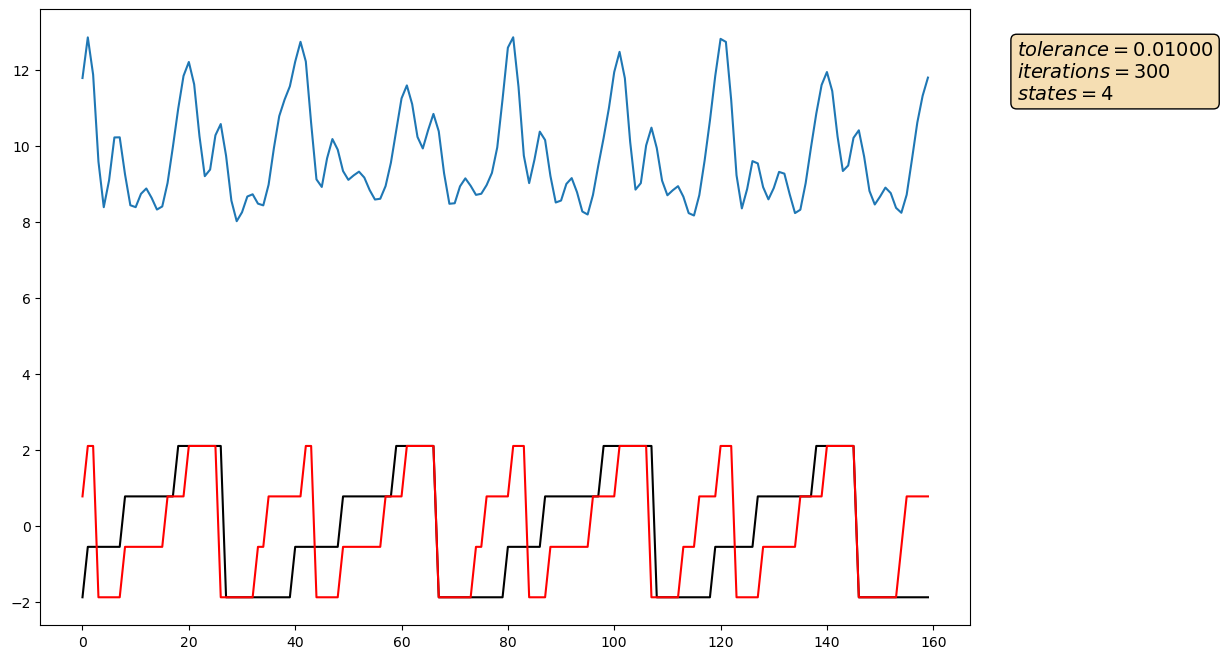


Avg. Sym - 1.014 M1 - Avg. Sym - 1.014 M1  :  0.55446
Avg. Sym - 1.014 M1 - Avg. Sym - 1.012 M2  :  0.55713
Avg. Sym - 1.014 M1 - Avg. Sym - 0.919 M1  :  0.48252
Avg. Sym - 1.014 M1 - Avg. Sym - 0.92 M2  :  0.48544

Avg. Sym - 1.012 M2 - Avg. Sym - 1.014 M1  :  0.55406
Avg. Sym - 1.012 M2 - Avg. Sym - 1.012 M2  :  0.58351
Avg. Sym - 1.012 M2 - Avg. Sym - 0.919 M1  :  0.45300
Avg. Sym - 1.012 M2 - Avg. Sym - 0.92 M2  :  0.47556

Avg. Sym - 0.919 M1 - Avg. Sym - 1.014 M1  :  0.46094
Avg. Sym - 0.919 M1 - Avg. Sym - 1.012 M2  :  0.42646
Avg. Sym - 0.919 M1 - Avg. Sym - 0.919 M1  :  0.77927
Avg. Sym - 0.919 M1 - Avg. Sym - 0.92 M2  :  0.66149

Avg. Sym - 0.92 M2 - Avg. Sym - 1.014 M1  :  0.48432
Avg. Sym - 0.92 M2 - Avg. Sym - 1.012 M2  :  0.46919
Avg. Sym - 0.92 M2 - Avg. Sym - 0.919 M1  :  0.65401
Avg. Sym - 0.92 M2 - Avg. Sym - 0.92 M2  :  0.61196


In [33]:
import copy
import seaborn as sns

new_trial_types = list(new_trial_types)

test_predict = strides_test[new_trial_types[0]][1]
min_predict = np.min(test_predict[:,1])
max_predict = np.max(test_predict[:,1])

def align_states(trained_hmm_model, roll_amount=0):
    new_hmm = copy.deepcopy(trained_hmm_model)
    array_order = np.roll(np.arange(num_states), roll_amount)

    new_hmm.model.transmat_ = new_hmm.model.transmat_[array_order,: ]
    for i, row in enumerate(new_hmm.model.transmat_):
        new_hmm.model.transmat_[i] = np.roll(new_hmm.model.transmat_[i], roll_amount)
        
    new_hmm.model.means_ = new_hmm.model.means_[array_order, :]
    new_hmm.model.covars_ = new_hmm.model.covars_[array_order, :]
    new_hmm.model.startprob_ = new_hmm.model.startprob_[array_order]
    return new_hmm 

pred_vals = np.ones(num_states)
for i in range(num_states):
    pred_vals[i] = min_predict + ((i * (max_predict - min_predict)) / (num_states - 1))

    
# roll_amounts = {'Pre': [0,3,0,0,2],
#                'PostRehab': [0,3,1,2,1],
#                'CueingRemoved': [2,2,0,1,0]}

roll_amounts = {}
match_trials = {}

for trial in new_trial_types:
    roll_amounts[trial] =[0 for i in range(num_models_train)]
    match_trials[trial] = 0

# roll_amounts = {'Pre': [0,0,0,0,0],
#                'PostRehab': [0,0,0,0,0],
#                'CueingRemoved': [0,0,0,0,0]}

# match_trials = {'Pre': 0,
#                'PostRehab':0,
#                'CueingRemoved':0}

shift_all = 0

def find_best_alignment(hmm_1, hmm_2, test_stride, n_states):
    min_distance = 9999999
    best_roll = 0
    
    for j in range(n_states):
        new_hmm = align_states(hmm_2, j)
        prediction_1 = hmm_1.model.predict(test_stride)
        prediction_2 = new_hmm.model.predict(test_stride)
        
        distance = np.sum((prediction_1 - prediction_2) ** 2)
        if (distance < min_distance):
            min_distance = distance
            best_roll = j
            
    return best_roll

predictions = {}
hmm_models_aligned_states = {}
for i, trial_type in enumerate(new_trial_types):
    predictions[trial_type] = []
    hmm_models_aligned_states[trial_type] = []
    match_trials[trial_type] = find_best_alignment(hmm_models[new_trial_types[0]][0], hmm_models[trial_type][0], test_predict, num_states)
    
    for j in range(num_models_train):
        roll_amounts[trial_type][j] = find_best_alignment(hmm_models[trial_type][0], hmm_models[trial_type][j], test_predict, num_states) + match_trials[trial_type]
        # roll_amounts[trial_type][j] = 0
        hmm_models_aligned_states[trial_type].append(align_states(hmm_models[trial_type][j], roll_amounts[trial_type][j] + shift_all))
        predictions[trial_type].append(hmm_models_aligned_states[trial_type][-1].model.predict(test_predict))
print(roll_amounts[new_trial_types[1]][0])
fig, ax = plt.subplots()
fig.set_size_inches(12,8)
plt.plot(test_predict[:,0])

plt.plot([pred_vals[j] for j in predictions[new_trial_types[0]][0]], 'k')
plt.plot([pred_vals[j] for j in predictions[new_trial_types[0]][3]], 'r')

# plt.plot([pred_vals[j] for j in predictions_post[4]], 'k')
# plt.plot([pred_vals[j] for j in predictions_post[2]], 'r')

def trial_avg_and_CI(signal_set):
    conf_int_mult = 1.00    # confidence interval multiplier for 1 std

    avg_signal = np.mean(signal_set, axis=0)
    std_signal = np.std(signal_set, axis=0)
    upper_bound = avg_signal + (conf_int_mult * std_signal)
    lower_bound = avg_signal - (conf_int_mult * std_signal)

    return avg_signal, upper_bound, lower_bound

def confidence_plot(plot_signals, fig_ax, trial_num):
    plot_signals = trial_avg_and_CI(plot_signals)
    x = np.arange(len(plot_signals[0]))
    fig_ax.plot(x, plot_signals[0], color=plot_colors[trial_num])
    fig_ax.fill_between(x, plot_signals[1], plot_signals[2], color=plot_colors[trial_num], alpha=0.2)

# confidence_plot(np.array([[pred_vals[k] for k in predictions['Pre'][j]] for j in range(5)]), ax, 0)
# confidence_plot(np.array([[pred_vals[k] for k in predictions['PostRehab'][j]] for j in range(5)]), ax, 1)
# confidence_plot(np.array([[pred_vals[k] for k in predictions['CueingRemoved'][j]] for j in range(5)]), ax, 2)

# for j in range(5):
#     plt.plot([pred_vals[k] for k in predictions['Pre'][j]], 'r', alpha = ((j+1) / 5) * 1)
# for j in range(5):
#     plt.plot([pred_vals[k] for k in predictions['PostRehab'][j]], 'k', alpha = ((j+1) / 5) * 1)
# for j in range(5):
#     plt.plot([pred_vals[k] for k in predictions['CueingRemoved'][j]], 'b', alpha = ((j+1) / 5) * 1)
# for j in range(5):
#     plt.plot([pred_vals[k] for k in predictions_post[j]], 'r', alpha = ((j+1) / 5) * 1)

# plt.plot([pred_vals[k] for k in prediction_post], 'k')

textstr = '\n'.join((
    r'$tolerance=%.5f$' % (train_tolerance, ),
    r'$iterations=%d$' % (train_iterations, ),
    r'$states=%d$' % (num_states, )))
props = dict(boxstyle='round', facecolor='wheat', alpha=1)
ax.text(1.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.show()




q_matrix = np.zeros((num_states, num_states))
div_scores = np.zeros((num_states, num_states))


def calculate_state_correspondence_matrix(hmm_1, hmm_2, n_states):
    def calculate_stationary_distribution(hmm):
        eigenvals, eigenvectors = np.linalg.eig(hmm.model.transmat_.T)
        stationary = np.array(eigenvectors[:, np.where(np.abs(eigenvals - 1.) < 1e-8)[0][0]])
        stationary = stationary / np.sum(stationary)
        return np.expand_dims(stationary.real, axis=-1)
    
    def calculate_KL_div(hmm_model_1, hmm_model_2, state_model_1, state_model_2):
        means_1 = np.expand_dims(hmm_model_1.means_[state_model_1], axis=-1)
        means_2 = np.expand_dims(hmm_model_2.means_[state_model_2], axis=-1)
        
        covars_1 = hmm_model_1.covars_[state_model_1]
        covars_2 = hmm_model_2.covars_[state_model_2]
        
        # print((means_2 - means_1).T.shape)
        # print(covars_2.shape)
        term_1 = (means_2 - means_1).T @ np.linalg.inv(covars_2) @ (means_2 - means_1)
        term_2 = np.trace(np.linalg.inv(covars_2) @ covars_1)
        term_3 = np.log(np.linalg.det(covars_1) / np.linalg.det(covars_2))
        term_4 = len(covars_1)

        kl_divergence = 0.5 * (term_1 + term_2 - term_3 - term_4)

        return kl_divergence
    
    kl_state_comparisons = np.zeros((n_states, n_states))
    pi_1 = calculate_stationary_distribution(hmm_1)
    pi_2 = calculate_stationary_distribution(hmm_2)
    total_expected_similarity = 0
    
    # print(pi_1)
    # print(pi_2)
    
    for i in range(n_states):
        for j in range(n_states):
            kl_state_comparisons[i,j] = 0.5 * (calculate_KL_div(hmm_1.model, hmm_2.model, i, j) + calculate_KL_div(hmm_2.model, hmm_1.model, i, j))
            total_expected_similarity = total_expected_similarity + (pi_1[i] * pi_2[j] * kl_state_comparisons[i,j])
    # print(total_expected_similarity)
    # print()
    k = 1
    s_e = np.exp(-k * kl_state_comparisons)
    # print(s_e)
    # print()
    s_e = 1 / kl_state_comparisons
    # print(s_e)
    # pi_1.T @ pi_2 should produce a 3x3 matrix (pi_1i * pi_2j)
    q_matrix = ((pi_1 @ pi_2.T) * s_e) / total_expected_similarity
    
    return q_matrix
    

def calculate_gini_index(q_matrix, n_states):

    def calc_gini(vector):
        vector = np.sort(vector)
        l1_norm = np.linalg.norm(vector, 1)
        a = 0
        for i in range(1, n_states+1):
            a = a + (vector[i-1] / l1_norm) * ((n_states - i + 0.5) / (n_states - 1))
        
        vec_sparsity = (n_states / (n_states - 1)) - (2 * a)
        
        return vec_sparsity
 
    r = (1 / n_states) * np.sum([calc_gini(row) for row in q_matrix])
    c = (1 / n_states) * np.sum([calc_gini(column) for column in q_matrix.T])
    
    gini_index = 0.5 * (r + c)
    return gini_index
        

# print(new_hmms[0].model.means_.shape)
# print(new_hmms[0].model.covars_.shape)
trial_types_print = ['Avg. Sym - ' + str(np.round(np.mean(trial_syms), 3)) for trial_syms in training_symmetries]

for i in range(len(new_trial_types)):
    print()
    for j in range(len(new_trial_types)):
        sum_dif = 0
        count = 0
        for k in range(num_models_train):
            if(i == j):
                indices = [a for a in range(num_models_train) if (not a == k)]
            else:
                indices = np.arange(num_models_train)
            for m in indices:
                x = calculate_state_correspondence_matrix(hmm_models_aligned_states[new_trial_types[i]][k], hmm_models_aligned_states[new_trial_types[j]][m], num_states)
                sum_dif = sum_dif + calculate_gini_index(x, num_states)
                count = count+1
        
        mean_dif = sum_dif / count
        
        print('%s - %s  :  %.5f' % (new_trial_types[i], new_trial_types[j], mean_dif))


In [ ]:
from sklearn.metrics import mean_squared_error as mse

def element_wise_var(array_of_matrices):
    var_array = np.zeros((array_of_matrices.shape[1], array_of_matrices.shape[2]))
    for i in range(array_of_matrices.shape[1]):
        for j in range(array_of_matrices.shape[2]):

            var_array[i,j] = np.var([x[i,j] for x in array_of_matrices])
    
    return np.mean(var_array)
            
def average_transmat_mse(mean_no_constraint_model, comparison_models):
    return np.mean([mse(mean_no_constraint_model, x) for x in comparison_models])
    
    
for trial_type in trial_types:
    norm_models = [m.model.transmat_ for m in hmm_models_aligned_states[trial_type]]
    lr_models = [m.model.transmat_ for m in hmm_models_l_to_r_aligned_states[trial_type]]
    print('Variance of transition matrices, norm (%s): ' % (trial_type), element_wise_var(np.array(norm_models)) )
    print('Variance of transition matrices, l_to_r (%s): ' % (trial_type), element_wise_var(np.array(lr_models)) )
    print()
    print('MSE of transition matrices, norm (%s): %0.5f' % (trial_type, average_transmat_mse(np.mean(norm_models, axis=0), norm_models)) )
    print('MSE of transition matrices, L to R (%s): %0.5f' % (trial_type, average_transmat_mse(np.mean(norm_models, axis=0), lr_models)) )
    print('-------------------------------------------------------------------------------------')

sns.heatmap(hmm_models_l_to_r_aligned_states[trial_types[0]][0].model.covars_[0])
plt.figure()
sns.heatmap(hmm_models_l_to_r_aligned_states[trial_types[0]][8].model.covars_[0])
          

KeyError: 'Avg. Sym - 1.018'

###### 